In [1]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

import pprint

import pandas as pd
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from pathlib import Path

from language_structure import *
from train import batch_iter, load
from model import *

base = Path('../aclImdb')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
traindf = pd.read_csv('train.csv')
lang = load_model()
lang = lang.top_n_words_model(10000)

In [2]:
from utils import to_input_tensor

In [198]:
# Sample Example from dataset
batch_size = 3
df = traindf[traindf.file_length < 25]
for sents, targets in batch_iter(lang, df, batch_size, shuffle=True):
    break
max(map(len, sents))

23

In [199]:
" ".join([lang.id2word[d] for d in [lang.get_id(w) for w in sents[0]]])

'this movie will always be a broadway and movie classic as long as there are still people who sing dance and act .'

In [200]:
n_embed, embed_size = lang.n_words, 10
embedding = nn.Embedding(n_embed, embed_size)

In [201]:
x, lengths = to_input_tensor(lang, sents, device)
em = embedding(x)
em.shape

torch.Size([23, 3, 10])

In [7]:
" ".join(sents[0])

'as usual sean connery does a great job . lawrence fishburn is good but i have a hard time not seeing him as ike turner .'

In [202]:
hidden_size = 3
gru = nn.GRU(embed_size, hidden_size, bias=True)

In [203]:
x = nn.utils.rnn.pack_padded_sequence(em, lengths)
output, hidden = gru(x)
output, _ = nn.utils.rnn.pad_packed_sequence(output)
output.shape

torch.Size([23, 3, 3])

In [126]:
output.transpose(0, 1)[0].shape

torch.Size([23, 3])

In [103]:
old_attn_mask = torch.ones_like(sent_encoded)
old_attn_mask[0, :] = -float('Inf')

In [104]:
attn.shape, sent_encoded.shape

(torch.Size([3, 26, 26]), torch.Size([3, 26, 3]))

In [188]:
attn_vec = attn.unsqueeze(-1) * sent_encoded
attn_vec = torch.sum(attn_vec, 1)
attn_vec.shape

torch.Size([23, 3])

In [192]:
total_hidden = torch.cat([attn_vec, sent_encoded], dim=1)
total_hidden.shape, total_hidden[0]

(torch.Size([23, 6]),
 tensor([-0.0985, -0.1809,  0.0910, -0.5316, -0.2783,  0.4990],
        grad_fn=<SelectBackward>))

In [131]:
attn.unsqueeze(-1) * sent_encoded, sent_encoded.shape

(tensor([[-0.0000, -0.0000,  0.0000],
         [ 0.0106,  0.0033,  0.0150],
         [ 0.0165,  0.0026,  0.0247],
         [ 0.0221,  0.0076,  0.0154],
         [ 0.0134,  0.0133,  0.0043],
         [ 0.0035, -0.0250, -0.0034],
         [ 0.0163, -0.0103, -0.0057],
         [ 0.0052, -0.0023,  0.0185],
         [ 0.0243, -0.0045,  0.0175],
         [ 0.0117, -0.0337,  0.0093],
         [ 0.0032,  0.0010,  0.0072],
         [ 0.0133,  0.0166, -0.0025],
         [ 0.0139,  0.0137, -0.0042],
         [-0.0316,  0.0124, -0.0029],
         [-0.0768, -0.0651,  0.0015],
         [-0.0375, -0.0340,  0.0034],
         [-0.0180, -0.0215, -0.0003],
         [-0.0614, -0.0607, -0.0004],
         [ 0.0076, -0.0115, -0.0035],
         [ 0.0223, -0.0049, -0.0006],
         [-0.0208,  0.0176,  0.0010],
         [-0.0242,  0.0325,  0.0051],
         [-0.0120, -0.0280, -0.0086]], grad_fn=<MulBackward0>),
 torch.Size([23, 3]))

In [132]:
attn_vec = torch.sum(attn.unsqueeze(-1) * sent_encoded, dim=0)
attn_vec.shape # hidden_dim

torch.Size([3])

In [140]:
total_hidden = torch.cat([attn_vec, word_encoded.squeeze()])
total_hidden, total_hidden.shape

(tensor([-0.0985, -0.1809,  0.0910, -0.5316, -0.2783,  0.4990],
        grad_fn=<CatBackward>), torch.Size([6]))

In [237]:
n_classes = 1
lin = nn.Linear(2 * hidden_size, n_classes)
# torch.sigmoid(lin(total_hidden))

# Sentence Self-Attention RNN

In [111]:
sent_encoded = output.transpose(0, 1)[0]

# Make Attention Mask
attn_mask = torch.eye(max(lengths)) * -float('Inf')
attn_mask[torch.isnan(attn_mask)] = 0
attn_mask[attn_mask == 0] = 1

# Attention MM + Softmax
attn = torch.mm(sent_encoded, sent_encoded.transpose(0, 1))
attn = torch.softmax(attn * attn_mask, dim=1)

# Sum along 
attn_vec = attn.unsqueeze(-1) * sent_encoded
attn_vec = torch.sum(attn_vec, 1)

total_hidden_single = torch.cat([attn_vec, sent_encoded], dim=1)

# Batch Self-Attention RNN

In [170]:
x, lengths = to_input_tensor(lang, sents, device)
lengths

[25, 24, 13]

In [216]:
I = torch.eye(max(lengths))
attn_mask = torch.stack([I] * batch_size)
for i, l in zip(list(range(batch_size)), lengths):
    attn_mask[i, :, l:] = 1
attn_mask

tensor([[[1., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 0., 0., 1.]],

        [[1., 0., 0.,  ..., 0., 0., 1.],
         [0., 1., 0.,  ..., 0., 0., 1.],
         [0., 0., 1.,  ..., 0., 0., 1.],
         ...,
         [0., 0., 0.,  ..., 1., 0., 1.],
         [0., 0., 0.,  ..., 0., 1., 1.],
         [0., 0., 0.,  ..., 0., 0., 1.]],

        [[1., 0., 0.,  ..., 1., 1., 1.],
         [0., 1., 0.,  ..., 1., 1., 1.],
         [0., 0., 1.,  ..., 1., 1., 1.],
         ...,
         [0., 0., 0.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 1., 1., 1.]]])

In [210]:
sent_encoded = output.transpose(0, 1)

attn_mask = torch.eye(max(lengths))

attn = torch.bmm(sent_encoded, sent_encoded.transpose(1, 2))
attn.data.masked_fill_(attn_mask.byte(), -float('inf'))

attn = torch.softmax(attn, dim=2)
attn[torch.isnan(attn)] = 0

attn_vec = attn.unsqueeze(-1) * sent_encoded.unsqueeze(1)
attn_vec = attn_vec.sum(-2)

total_hidden = torch.cat([attn_vec, sent_encoded], dim=-1)
(total_hidden[0] == total_hidden_single).all()

tensor(0, dtype=torch.uint8)

In [46]:
total_hidden = total_hidden.transpose(-1, -2)
total_hidden.shape

torch.Size([3, 6, 26])

In [52]:
max_hidden, idx = torch.max(total_hidden, -1)
max_hidden.unsqueeze(-1).shape

torch.Size([3, 6, 1])

In [91]:
class RNNAttention(nn.Module):
    def __init__(self, language, device, embed_dim, hidden_dim, num_embed, n_classes):
        super().__init__()
        self.device = device
        self.language = language 
        
        self.embedding = nn.Embedding(num_embed, embed_dim)
        self.gru = nn.GRU(embed_dim, hidden_dim, bias=True)
        self.classify = nn.Linear(2 * hidden_dim, n_classes)
        
    def forward(self, sents):
        # Embed the sequence
        x, lengths = to_input_tensor(self.language, sents, self.device)
        x_embed = self.embedding(x)
        # RNN encoding
        x = nn.utils.rnn.pack_padded_sequence(x_embed, lengths)
        x, _ = self.gru(x)
        x, _ = nn.utils.rnn.pad_packed_sequence(x)

        # batch, seq, hidden
        x = x.transpose(0, 1)
        # attention mask 
        attn_mask = torch.eye(max(lengths)) * -float('Inf')
        attn_mask[torch.isnan(attn_mask)] = 0
        attn_mask[attn_mask == 0] = 1

        # apply attention over RNN outputs
        attn = torch.bmm(x, x.transpose(1, 2))
        attn = torch.softmax(attn * attn_mask, dim=2)
        attn[torch.isnan(attn)] = 0
        attn_vec = attn.unsqueeze(-1) * x.unsqueeze(1)
        attn_vec = attn_vec.sum(-2)
        attn_out = torch.cat([attn_vec, x], dim=-1)
        
        # max pool over sequence 
        attn_out = attn_out.transpose(-1, -2)
        max_vec, _ = torch.max(attn_out, -1)
        max_vec = max_vec.unsqueeze(-2)
        
        # binary classification activ.
        y = torch.sigmoid(self.classify(max_vec)).squeeze()
        return y        

# Attention Extraction

In [120]:
from model import *

In [253]:
class RNN_Self_Attention(SaveModel):
    def __init__(self, language, device, batch_size, embed_dim, hidden_dim, num_embed, n_classes):
        super().__init__()
        self.device = device
        self.language = language 
        self.batch_size = batch_size
        
        self.embedding = nn.Embedding(num_embed, embed_dim)
        self.gru = nn.GRU(embed_dim, hidden_dim, bias=True)
        self.classify = nn.Linear(2 * hidden_dim, n_classes)
        self.attention = RNNAttention()
        
    def forward(self, sents):
        # Embed the sequence
        x, lengths = to_input_tensor(self.language, sents, self.device)
        x_embed = self.embedding(x)
        # RNN encoding
        x = nn.utils.rnn.pack_padded_sequence(x_embed, lengths)
        x, _ = self.gru(x)
        x, _ = nn.utils.rnn.pad_packed_sequence(x)
        
        x = x.transpose(0, 1)
        # get attention over RNN outputs 
        I = torch.eye(max(lengths))
        attn_mask = torch.stack([I] * self.batch_size)
        for i, l in zip(list(range(self.batch_size)), lengths):
            attn_mask[i, :, l:] = 1
            attn_mask[i, l:, :] = 1
        
        attn = self.attention(x, attn_mask)
        attn_vec = attn.unsqueeze(-1) * x.unsqueeze(1)
        attn_vec = attn_vec.sum(-2)
        attn_out = torch.cat([attn_vec, x], dim=-1)
        
        # max pool over sequence 
        attn_out = attn_out.transpose(-1, -2)
        max_vec, _ = torch.max(attn_out, -1)
        max_vec = max_vec.unsqueeze(-2)
        
        # binary classification activ.
        y = torch.sigmoid(self.classify(max_vec)).squeeze()
        return y        
    
class RNNAttention(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x, attn_mask):
        # apply attention over RNN outputs (batch, seq, hidden)
        attn = torch.bmm(x, x.transpose(1, 2))
        attn.data.masked_fill_(attn_mask.byte(), -float('inf'))
        attn = torch.softmax(attn, dim=2)
        # account for padding 
        attn.data.masked_fill_(attn_mask.byte(), 0)
        return attn

In [254]:
model = RNN_Self_Attention(lang, device, batch_size, 25, 30, lang.n_words, 1)

In [255]:
list(model.modules())

[RNN_Self_Attention(
   (embedding): Embedding(10004, 25)
   (gru): GRU(25, 30)
   (classify): Linear(in_features=60, out_features=1, bias=True)
   (attention): RNNAttention()
 ),
 Embedding(10004, 25),
 GRU(25, 30),
 Linear(in_features=60, out_features=1, bias=True),
 RNNAttention()]

In [256]:
attentions = model._modules.get('attention')
tracked_attention_weigths = []
def show(m, i, o): 
    w = o
    tracked_attention_weigths.append(w)
hook = attentions.register_forward_hook(show)

In [257]:
y = model(sents)
hook.remove()

In [258]:
w = tracked_attention_weigths[0]

1.0


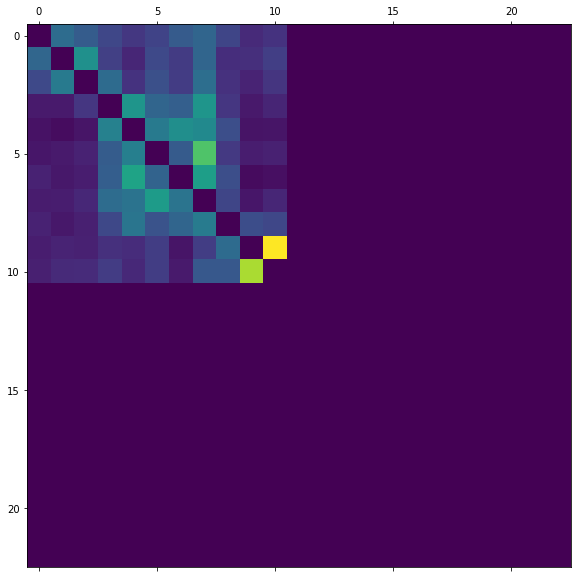

In [263]:
batch_index = 2
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
attention = w.detach().numpy().squeeze()
attention = attention[batch_index] if type(batch_index) == int else attention
ax.matshow(attention, cmap='viridis')
fontdict = {'fontsize': 14}
print(np.sum(attention[0]))

# New Model 

In [5]:
# Sample Example from dataset
batch_size = 3
df = traindf[traindf.file_length < 25]
max_sentence_len = 25
for sents, targets in batch_iter(lang, df, batch_size, max_sentence_len, shuffle=True):
    break
max(map(len, sents))

14

In [23]:
sentence = sents[0]
target = targets[0]
task = 0 #'<sentiment>'
task = torch.tensor([task] * batch_size)
task.shape

torch.Size([3])

In [81]:
x, lengths = to_input_tensor(lang, sents, device)
x = x.transpose(0, 1)
x.shape

torch.Size([3, 14])

In [82]:
embed_dim = 20
w_embedding = nn.Embedding(lang.n_words, embed_dim)
t_embedding = nn.Embedding(1, hidden_dim)

In [83]:
te = t_embedding(task).unsqueeze(-1)
te.shape

torch.Size([3, 30, 1])

In [59]:
hidden_dim = 30
linear = nn.Linear(embed_dim, hidden_dim)
classify = nn.Linear(hidden_dim, 1)

In [35]:
xe = w_embedding(x)

In [36]:
dropout = 0.3
mha = nn.MultiheadAttention(embed_dim, 1, dropout=dropout)

In [41]:
xa, _ = mha(xe, xe, xe)
x = linear(xa)
x.shape

torch.Size([3, 14, 30])

In [53]:
w = torch.bmm(x, te)
w.shape

torch.Size([3, 14, 1])

In [68]:
torch.softmax(w.squeeze(-1), -1).unsqueeze(-1)[0]

tensor([[3.3235e-06],
        [2.1673e-07],
        [1.1966e-03],
        [2.6087e-04],
        [3.0807e-03],
        [1.4841e-07],
        [7.4762e-01],
        [2.8914e-06],
        [5.5351e-03],
        [5.8624e-07],
        [2.2333e-04],
        [1.6494e-01],
        [2.8781e-06],
        [7.7139e-02]], grad_fn=<SelectBackward>)

In [55]:
weighted_attention = w * x
weighted_attention.shape

torch.Size([3, 14, 30])

In [57]:
wa = weighted_attention.transpose(1, 2)
wa.shape

torch.Size([3, 30, 14])

In [61]:
maxpool, _ = torch.max(wa, -1)
y = torch.sigmoid(classify(maxpool))
y

tensor([[5.2636e-04],
        [4.7082e-02],
        [5.3003e-05]], grad_fn=<SigmoidBackward>)

In [87]:
import torch.nn.functional as F

In [141]:
class TaskSpecificAttention(nn.Module):
    def __init__(self, language, device, embed_dim, hidden_dim, num_embed, num_heads, num_layers, dropout, n_classes):
        super().__init__()
        self.device = device
        self.language = language
        
        self.w_embedding = nn.Embedding(lang.n_words, embed_dim)
        self.t_embedding = nn.Embedding(num_layers, hidden_dim)
        self.dropout = nn.Dropout(dropout)
        
        self.mhas, self.linear_1, self.linear_2 = nn.ModuleList(), nn.ModuleList(), nn.ModuleList()
        self.ln_1, self.ln_2 = nn.ModuleList(), nn.ModuleList()
        self.tasks = []
        
        for i in range(num_layers):
            self.mhas.append(nn.MultiheadAttention(embed_dim, 1, dropout=dropout))
            self.linear_1.append(nn.Linear(embed_dim, hidden_dim))
            self.linear_2.append(nn.Linear(hidden_dim, embed_dim))
            self.tasks.append(i)
            
            self.ln_1.append(nn.LayerNorm(embed_dim, eps=1e-12))
            self.ln_2.append(nn.LayerNorm(hidden_dim, eps=1e-12))
        
        self.classify = nn.Linear(embed_dim, n_classes)
        
    def forward(self, sents):
        batch_size = len(sents)
        x, lengths = to_input_tensor(lang, sents, device)
        x = x.transpose(0, 1)
        # bs, seq, embed
        x = self.w_embedding(x)

        for task, mha, linear_1, linear_2, lnorm_1, lnorm_2 in zip(self.tasks, self.mhas, self.linear_1, self.linear_2, self.ln_1, self.ln_2):
            tasks = torch.tensor([task] * batch_size)
            te = self.t_embedding(tasks).unsqueeze(-1)
            
            x = lnorm_1(x)
            # bs, seq, embed
            x, _ = mha(x, x, x)
            # bs, seq, hidden
            x = linear_1(x)
            
            # task attention
            w = torch.bmm(x, te)
            w = torch.softmax(w.squeeze(-1), -1).unsqueeze(-1)
            weighted_attention = (w * x)
            x = self.dropout(weighted_attention)
            
            x = lnorm_2(x)
            # bs, seq, embed
            x = F.relu(linear_2(x))

        # bs, embed, seq
        x = x.transpose(1, 2)
        maxpool, _ = torch.max(x, -1)
        y = torch.sigmoid(self.classify(maxpool)).squeeze()
        
        return y

In [142]:
n_heads = 1
n_layers = 2
dropout = 0.3 

model = TaskSpecificAttention(lang, device, embed_dim, hidden_dim, lang.n_words, n_heads, n_layers, dropout, 1)

In [143]:
model(sents)

tensor([0.4007, 0.4548, 0.4895], grad_fn=<SqueezeBackward0>)